<a href="https://colab.research.google.com/github/kalingasajja/Forecasting-Stocks/blob/main/Forecasting_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential

from keras.layers import Dense,Activation,Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


2. Reading data

In [4]:
data = pd.read_csv('/content/INFY20002008.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              2496 non-null   int64  
 1   Symbol                  2496 non-null   object 
 2   Series                  2496 non-null   object 
 3   Date                    2496 non-null   object 
 4   Prev Close              2496 non-null   float64
 5   Open Price              2496 non-null   float64
 6   High Price              2496 non-null   float64
 7   Low Price               2496 non-null   float64
 8   Last Price              2496 non-null   float64
 9   Close Price             2496 non-null   float64
 10  Average Price           2496 non-null   float64
 11  Total Traded Quantity   2496 non-null   int64  
 12  Turnover                2496 non-null   float64
 13  No. of Trades           2496 non-null   object 
 14  Deliverable Qty         2496 non-null   

3.Extracting only required features

In [5]:
data = data[['Date','Average Price']]

4. Scaling and Splitting

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_price = scaler.fit_transform(data.loc[:,'Average Price'].values.reshape(-1,1))

train_size = int(data.shape[0]*0.75)
train,test = scaled_price[0:train_size,:],scaled_price[train_size:data.shape[0],:]
print("Number of entries (training set , testing set): "+str((len(train),len(test))))

Number of entries (training set , testing set): (1872, 624)


In [7]:
def create_dataset(scaled_price,window_size=1):
  data_X , data_Y = [],[]
  for i in range(len(scaled_price)-window_size-1):
    a = scaled_price[i:(i+window_size),0]
    data_X.append(a)
    data_Y.append(scaled_price[i+window_size,0])
  return (np.array(data_X),np.array(data_Y))

In [8]:
window_size = 3
train_X,train_Y = create_dataset(train,window_size)
test_X,test_Y = create_dataset(test,window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for keras
train_X = np.reshape(train_X,(train_X.shape[0],1,train_X.shape[1]))
test_X = np.reshape(test_X,(test_X.shape[0],1,test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(1868, 3)
New training data shape:
(1868, 1, 3)


In [9]:
model = Sequential()
model.add(LSTM(4,input_shape=(1,window_size)))
model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(train_X,train_Y,epochs=3,batch_size=1)


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1868/1868 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0118
Epoch 2/3
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.4784e-04
Epoch 3/3
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.5276e-04


In [10]:
def predict_and_score(model,X,Y):
  pred = scaler.inverse_transform(model.predict(X))
  orig_data = scaler.inverse_transform([Y])

  score= np.sqrt(mean_squared_error(orig_data[0],pred[:,0]))
  return (score,pred)

rmse_train,train_predict = predict_and_score(model,train_X,train_Y)
rmse_test,test_predict = predict_and_score(model,test_X,test_Y)


print("Training data scoren: %.2f RMSE " % rmse_train)
print("Test data score : %.2f RMSE " % rmse_test)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training data scoren: 294.55 RMSE 
Test data score : 68.74 RMSE 


In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, window_size)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(train_X,train_Y,epochs=30,batch_size=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0062
Epoch 2/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0016
Epoch 3/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 8.1087e-04
Epoch 4/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0011
Epoch 5/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 6.2686e-04
Epoch 6/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 6.0987e-04
Epoch 7/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.8394e-04
Epoch 8/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.7216e-04
Epoch 9/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.5125e-04
Epoch 10/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.1521e-04
Epoch 11/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.0085e-04
Epoch 12/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.1667e-04
Epoch 13/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0012
Epoch 14/30
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - lo

In [12]:
rmse_train,train_predict = predict_and_score(model,train_X,train_Y)
rmse_test,test_predict = predict_and_score(model,test_X,test_Y)


print("Training data scoren: %.2f RMSE " % rmse_train)
print("Test data score : %.2f RMSE " % rmse_test)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training data scoren: 243.97 RMSE 
Test data score : 58.45 RMSE 


In [13]:
train_predict_plot = np.empty_like(scaled_price)
train_predict_plot[:,:] = np.nan
train_predict_plot[window_size:len(train_predict)+window_size,:]=train_predict

test_predict_plot = np.empty_like(scaled_price)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+ (window_size*2) + 1:len(scaled_price)-1 , :]= test_predict

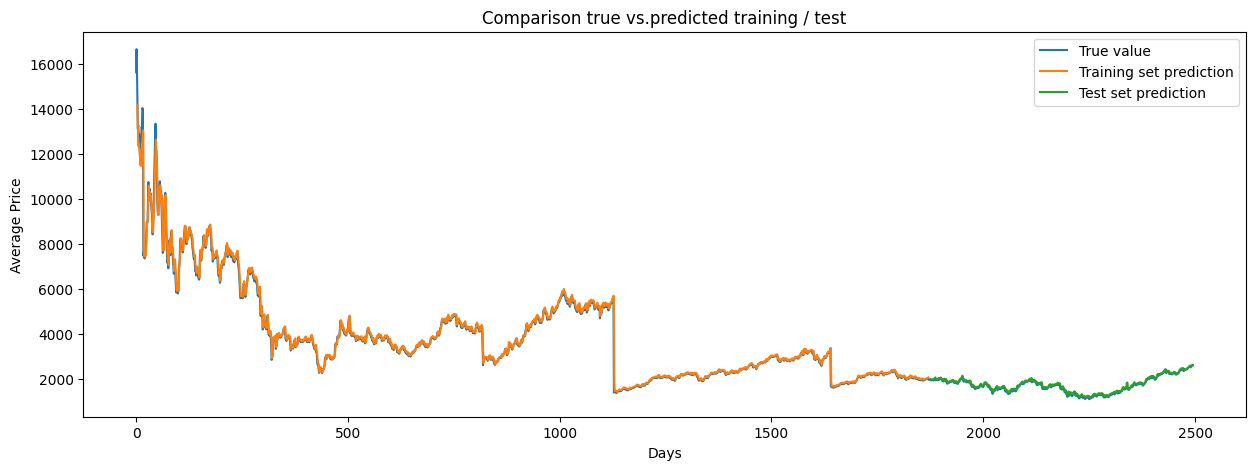

In [14]:
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(scaled_price),label="True value")
plt.plot(train_predict_plot,label="Training set prediction")
plt.plot(test_predict_plot,label="Test set prediction")
plt.xlabel("Days")
plt.ylabel("Average Price")
plt.title("Comparison true vs.predicted training / test")
plt.legend()
plt.show()

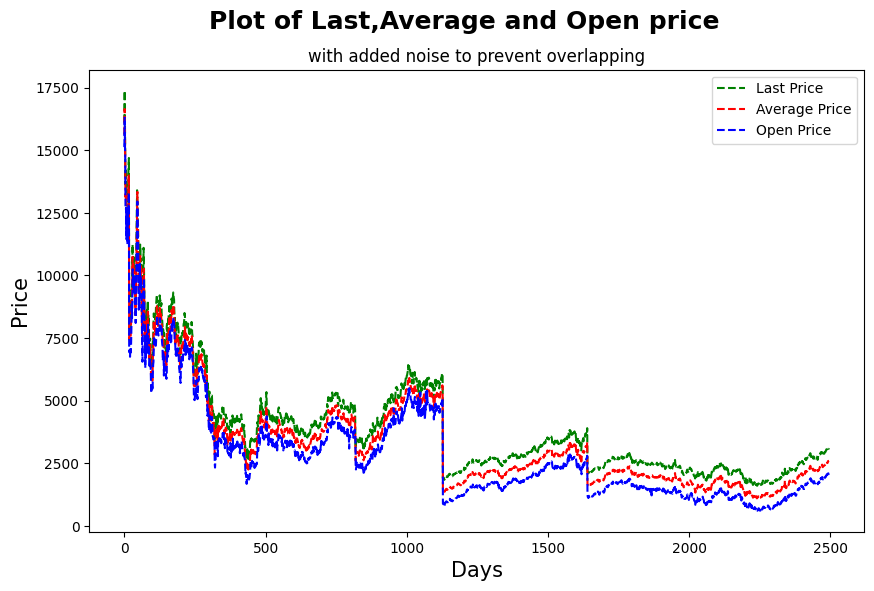

In [15]:
data1 = pd.read_csv("/content/INFY20002008.csv")

data1 = data1[['Last Price','Average Price','Open Price']].values

plt.figure(figsize=(10,6))
plt.plot(data1[:,0]+500,'--g',label='Last Price')
plt.plot(data1[:,1],'--r',label='Average Price')
plt.plot(data1[:,2]-500,'--b',label='Open Price')
plt.xlabel('Days',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.suptitle('Plot of Last,Average and Open price',fontsize=18,weight='bold')
plt.title('with added noise to prevent overlapping')
plt.legend()
plt.show()


In [16]:
def forecast_future(model, last_window, steps=10):
    future_predictions = []
    current_input = last_window.reshape(1, 1, -1)

    for _ in range(steps):
        pred = model.predict(current_input)
        future_predictions.append(pred[0, 0])

        # Slide window
        new_input = np.append(current_input[0, 0, 1:], pred[0, 0])
        current_input = new_input.reshape(1, 1, -1)

    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [17]:
last_window = test[-window_size:].flatten()
future_prices = forecast_future(model, last_window, steps=10)
print(future_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[2630.7   ]
 [2659.0186]
 [2687.7588]
 [2716.4907]
 [2745.2913]
 [2774.169 ]
 [2803.141 ]
 [2832.2236]
 [2861.4333]
 [2890.7874]]
